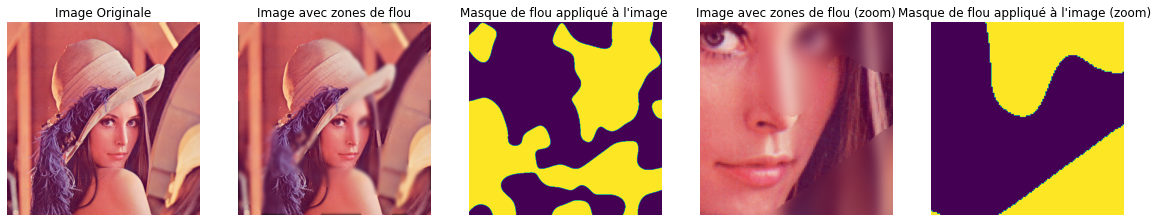

In [6]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def create_blur_kernel(kernel_size: int = 25) -> torch.Tensor:
    # Create a 2D Gaussian kernel
    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    y = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    x, y = torch.meshgrid(x, y, indexing='xy')
    sigma = kernel_size / 6  # Standard deviation
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()  # Normalize
    return kernel

def blur_image(image: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    batch_size, channels, height, width = image.shape
    kernel = kernel.expand(channels, 1, kernel.shape[2], kernel.shape[3])
    padding = kernel.shape[-1] // 2
    blurred_image = F.conv2d(image, kernel, padding=padding, groups=channels)
    return blurred_image

def generate_data_on_image(image: torch.Tensor, 
                           sigma1: float = 1., 
                           sigma2: float = 0.2, 
                           sigma: float = 25,
                           **factory_kwargs) -> torch.Tensor:
    
    batch_size, channels, image_size, _ = image.shape

    # Defining a grid directly on device
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x, y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # Initialize the result image
    result_image = torch.zeros_like(image)

    for c in range(channels):
        # We define a random smooth partition
        b = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp = F.conv2d(b, g[None,None], padding='same')  # Convolution
        
        omega_1 = gp > 0
        omega_2 = ~omega_1
        
        # We define two Gaussian random processes with different statistics
        b1 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp1 = F.conv2d(b1, g1[None,None], padding='same')
        
        b2 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp2 = F.conv2d(b2, g2[None,None], padding='same')
        
        # Now we put each process at the right place
        channel_image = gp1 * omega_1 + gp2 * omega_2
        # We smooth the result to avoid having a jump at the interfaces
        channel_image = F.conv2d(channel_image, g3[None,None], padding='same')

        # Normalize the channel image to [0,1]
        #channel_image = normalize_to_01(channel_image)

        # Combine the original image channel with the generated channel image
        result_image[:, c, :, :] = (image[:, c, :, :] + channel_image.squeeze(1)) / 2
    
    return result_image, omega_1.float()  # Convert omega_1 to float

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim=(-2, -1), keepdim=True)
    input /= input.amax(dim=(-2, -1), keepdim=True)
    return input

def apply_blur_zones(image: torch.Tensor, omega: torch.Tensor, kernel_size: int = 25) -> torch.Tensor:
    blur_kernel = create_blur_kernel(kernel_size).unsqueeze(0).unsqueeze(0).to(image.device)
    blurred_image = blur_image(image, blur_kernel)
    
    blurred_zones = omega * blurred_image
    non_blurred_zones = (1 - omega) * image
    
    final_image = blurred_zones + non_blurred_zones
    return final_image

# Load an image
image_path = "test_image.png"
image_pil = Image.open(image_path).convert('RGB')
image_np = np.array(image_pil)
image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()  # Convert to NCHW format and add batch dimension

# Apply the random process to the image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
processed_image_tensor, omega = generate_data_on_image(image_tensor, device=device)

# Apply blur to specific zones
# blurred_image_tensor = apply_blur_zones(processed_image_tensor, omega, kernel_size=25)

blurred_image_tensor = apply_blur_zones(image_tensor, omega, kernel_size=25)

# Convert the processed image back to numpy for visualization
blurred_image_np = blurred_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# Display the original and processed images
fig, axs = plt.subplots(1, 5, figsize=(20, 20))

axs[0].imshow(image_np)
axs[0].set_title('Image Originale')
axs[0].axis('off')
axs[1].imshow(blurred_image_np)
axs[1].set_title('Image avec zones de flou')
axs[1].axis('off')
axs[2].imshow(omega[0,0].detach().cpu().numpy())
axs[2].set_title("Masque de flou appliqué à l'image ")
axs[2].axis('off')

axs[3].imshow(blurred_image_np[256:384,256:384,:])
axs[3].set_title('Image avec zones de flou (zoom)')
axs[3].axis('off')
axs[4].imshow(omega[0,0][256:384,256:384].detach().cpu().numpy())
axs[4].set_title("Masque de flou appliqué à l'image (zoom) ")
axs[4].axis('off')

plt.show()


In [15]:
omega


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

# Définition du modèle et load modèle préentrainé

In [7]:
import torch.nn as nn
class DetectionZoneFlou(nn.Module):
    def __init__(self, num_channels=16, kernel_size = 5, bias=True):
        super().__init__()

        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_channels)
        self.bias = bias
        self.kernel_size = kernel_size
        self.pad = int((self.kernel_size - 1) / 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=bias,
            ),
            self.activation,
            self.bn
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )

        self.out = nn.Conv2d(
                in_channels=num_channels,
                out_channels=1,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        output = torch.sigmoid(self.out(x3))
        return output


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
model = DetectionZoneFlou().to(device)

In [10]:
state_dict = torch.load("best_model_pnp.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

# Récupération image flouté et mise en forme pour le modèle

In [11]:
image_flou = torch.Tensor(blurred_image_np[256:384,256:384,:])

# Prédiction du masque de flou

In [12]:
prediction = model((image_flou).unsqueeze(0).permute(3,0,1,2).to(device))

# Affichage resultat

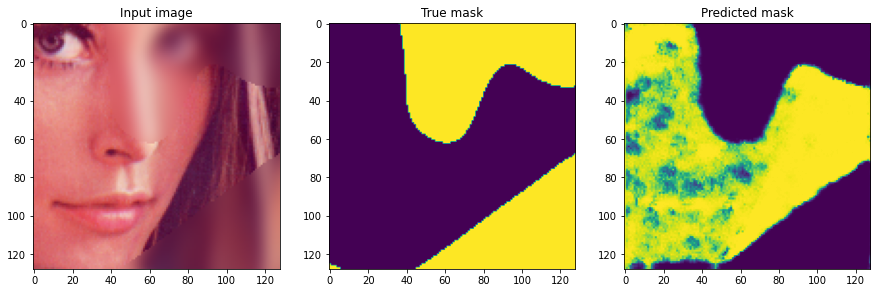

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
axes[0].imshow(blurred_image_np[256:384,256:384,:])
axes[0].set_title("Input image")

axes[1].imshow(omega[0,0][256:384,256:384].detach().cpu().numpy())
axes[1].set_title("True mask")

axes[2].imshow(prediction[0,0].detach().cpu().numpy())
axes[2].set_title("Predicted mask")
plt.show()